# Heart Disease Prediction

## Overview

This dataset consolidates information from two primary sources:
- UCI Machine Learning Repository - Heart Disease Dataset
- Kaggle - Heart Disease Dataset by Rasel Ahmed 

The primary aim is to predict the presence or absence of heart disease based on various patient metrics. <br>

Data Source and Acknowledgment
- Data was sourced from the UCI Machine Learning Repository and Kaggle.
- All patient data has been anonymized to ensure privacy.

Kaggle Link: https://www.kaggle.com/datasets/data855/heart-disease/data <br>
UCI Repository Link: https://archive.ics.uci.edu/dataset/45/heart+disease

## Data Dictionary:
- age: age in years
- sex: sex (1 = male; 0 = female)
- cp: chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- trestbps: resting blood pressure (in mm Hg on admission to the hospital)
- chol: serum cholestoral in mg/dl
- fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
- restecg: resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- thalach: maximum heart rate achieved
- exang: exercise induced angina (1 = yes; 0 = no)
- oldpeak: ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
- ca: number of major vessels (0-3) colored by flourosopy
- thal: Thallium heart scan
    - Value 3: normal 
    - Value 6: fixed defect
    - Value 7: reversable defect
- target (the lable):
    - 0 = no disease
    - 1 = disease




## Libraries

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import csv
import os
import pickle
import math

from scipy.stats import uniform
import optuna

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, \
      GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,\
      recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc, classification_report


## Data

In [2]:
# Data
df = pd.read_csv('../Data/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
df = df[df['ca'] < 4] #drop the wrong ca values
df = df[df['thal'] > 0] # drop the wong thal value
print(f'The length of the data now is {len(df)} instead of 303!')

The length of the data now is 296 instead of 303!


In [4]:
df = df.rename(
    columns = {'cp':'chest_pain_type', 
               'trestbps':'resting_blood_pressure', 
               'chol': 'cholesterol',
               'fbs': 'fasting_blood_sugar',
               'restecg' : 'resting_electrocardiogram', 
               'thalach': 'max_heart_rate_achieved', 
               'exang': 'exercise_induced_angina',
               'oldpeak': 'st_depression', 
               'slope': 'st_slope', 
               'ca':'num_major_vessels', 
               'thal': 'Thallium_heart_scan'}, 
    errors="raise")

## EDA

In [5]:
df.shape

(296, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        296 non-null    int64  
 1   sex                        296 non-null    int64  
 2   chest_pain_type            296 non-null    int64  
 3   resting_blood_pressure     296 non-null    int64  
 4   cholesterol                296 non-null    int64  
 5   fasting_blood_sugar        296 non-null    int64  
 6   resting_electrocardiogram  296 non-null    int64  
 7   max_heart_rate_achieved    296 non-null    int64  
 8   exercise_induced_angina    296 non-null    int64  
 9   st_depression              296 non-null    float64
 10  st_slope                   296 non-null    int64  
 11  num_major_vessels          296 non-null    int64  
 12  Thallium_heart_scan        296 non-null    int64  
 13  target                     296 non-null    int64  
dtyp

In [38]:
# numerical fearures 6
numerical_features = ['age', 'cholesterol', 'resting_blood_pressure', 'max_heart_rate_achieved', 'st_depression', 'num_major_vessels']

# categorical (binary)
bin_feats = ['sex', 'fasting_blood_sugar', 'exercise_induced_angina', 'target']

# caterorical (multi-)
nom_feats= ['chest_pain_type', 'resting_electrocardiogram', 'st_slope', 'Thallium_heart_scan']
categorical_features = nom_feats + bin_feats

In [39]:
df[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
age,296.0,54.523649,9.059471,29.0,48.0,56.0,61.00,77.0
cholesterol,296.0,247.155405,51.977011,126.0,211.0,242.5,275.25,564.0
resting_blood_pressure,296.0,131.604730,17.726620,94.0,120.0,130.0,140.00,200.0
max_heart_rate_achieved,296.0,149.560811,22.970792,71.0,133.0,152.5,166.00,202.0
st_depression,296.0,1.059122,1.166474,0.0,0.0,0.8,1.65,6.2
num_major_vessels,296.0,0.679054,0.939726,0.0,0.0,0.0,1.00,3.0


In [40]:
# Check for null values 
df.isna().sum()

age                          0
sex                          0
chest_pain_type              0
resting_blood_pressure       0
cholesterol                  0
fasting_blood_sugar          0
resting_electrocardiogram    0
max_heart_rate_achieved      0
exercise_induced_angina      0
st_depression                0
st_slope                     0
num_major_vessels            0
Thallium_heart_scan          0
target                       0
dtype: int64

There seems to be no null values.

In [41]:
# check for duplicated records
df.duplicated().sum()

np.int64(0)

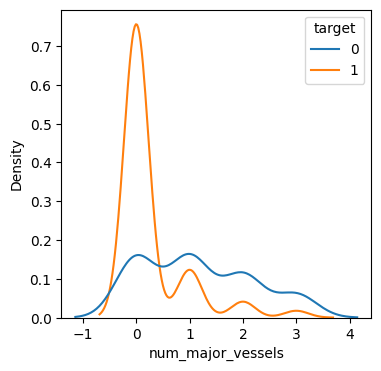

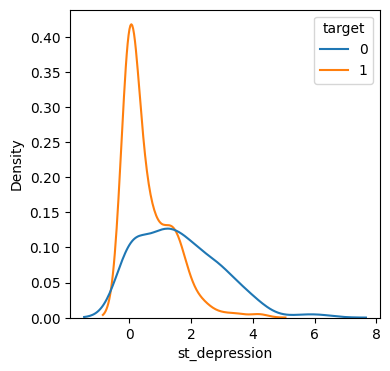

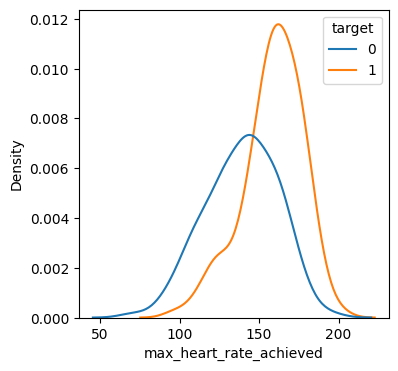

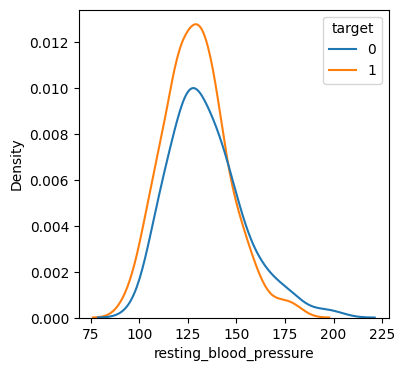

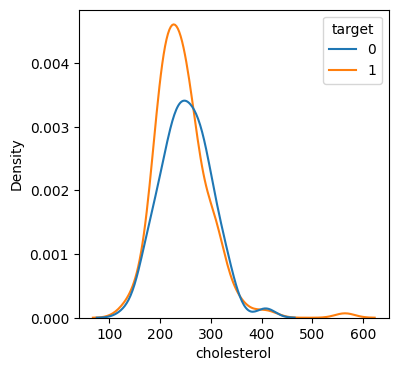

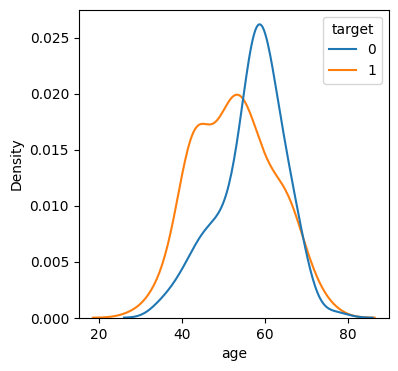

In [42]:
# KDE plots
num_feat = numerical_features[::-1]
for feature in num_feat:
    plt.figure(figsize=(4,4))
    sns.kdeplot(data=df, x=feature, hue='target')
    plt.show()

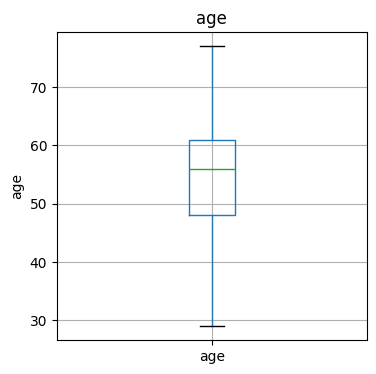

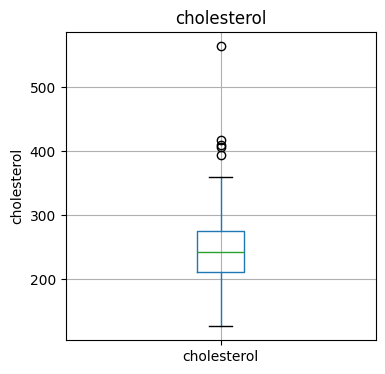

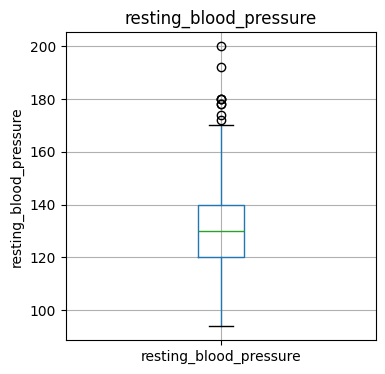

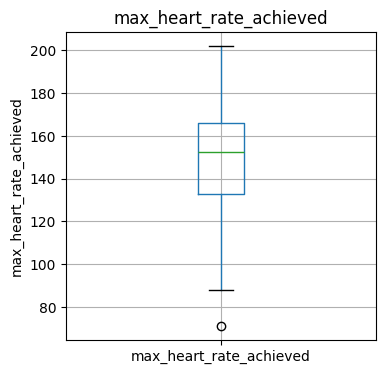

In [43]:
# Box plots
for feature in numerical_features:
  data = df.copy()

  if 0 in data[feature].unique():
    pass
  else:
    plt.figure(figsize=(4,4))
    data[feature] = data[feature]
    data.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

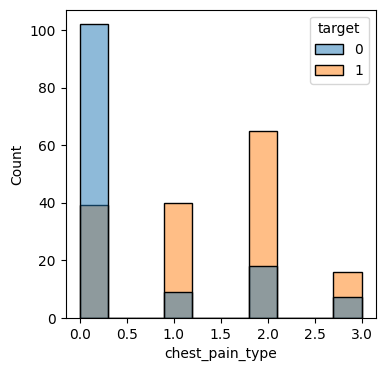

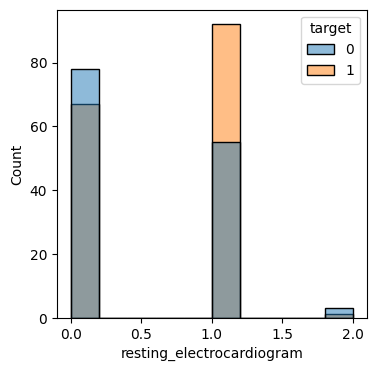

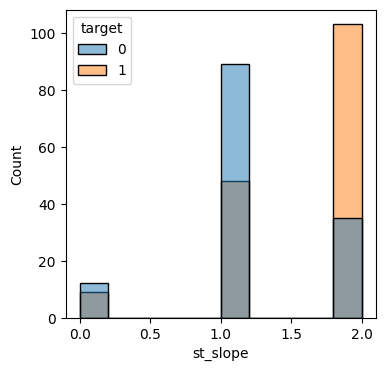

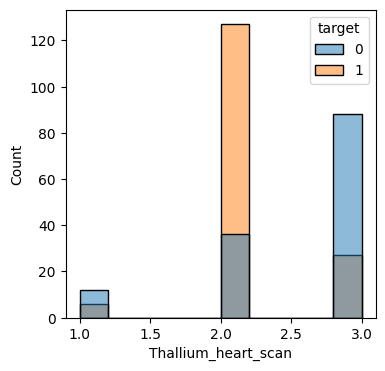

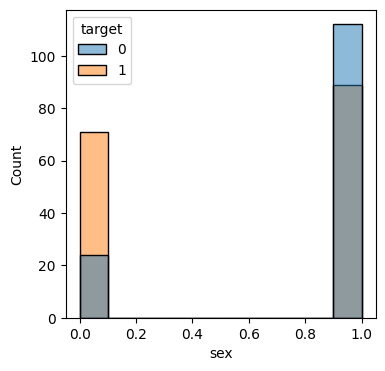

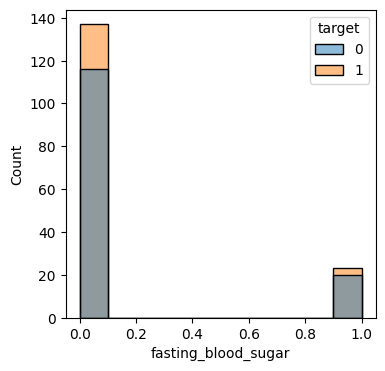

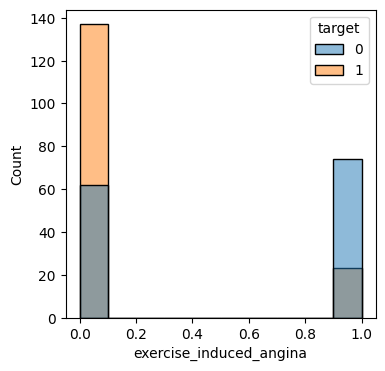

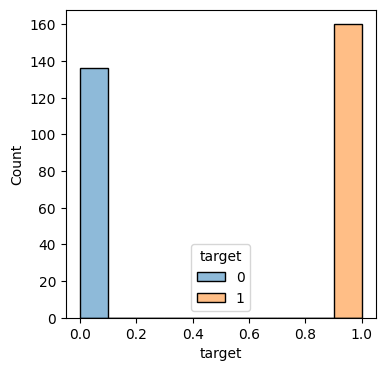

In [44]:
# bar plots
for feature in categorical_features:
    plt.figure(figsize=(4,4))
    sns.histplot(data=df, x=feature, hue='target')
    plt.show()

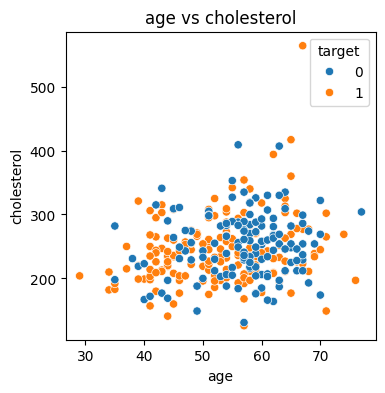

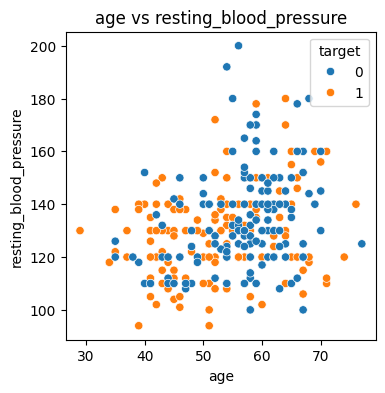

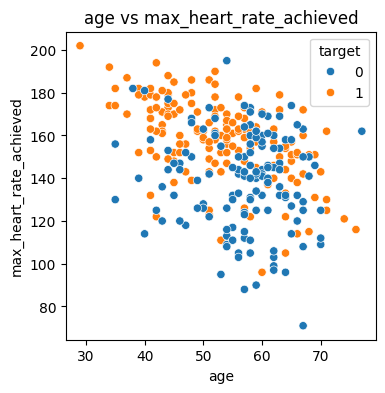

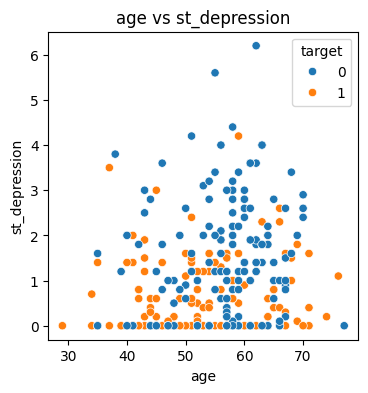

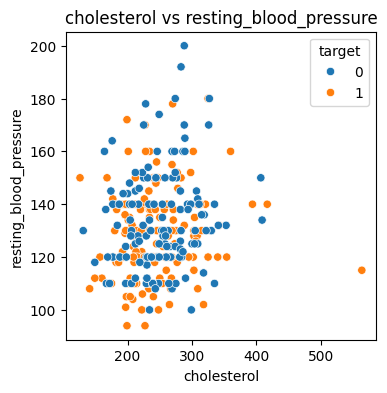

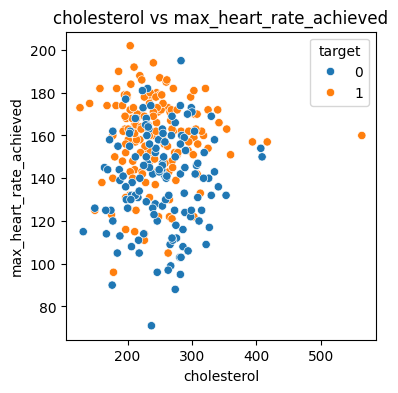

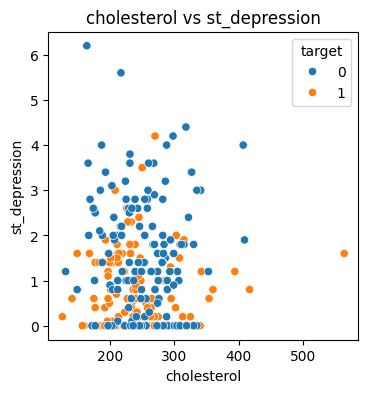

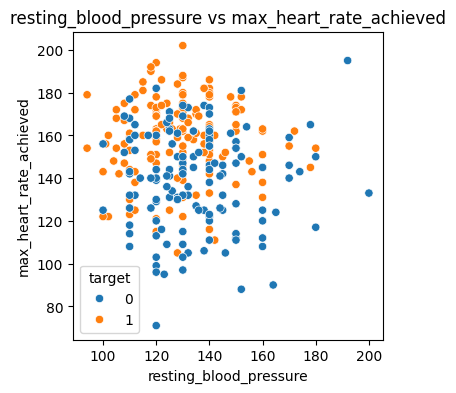

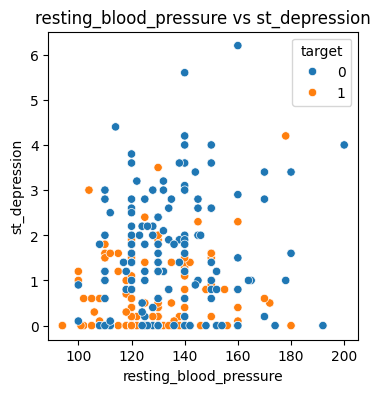

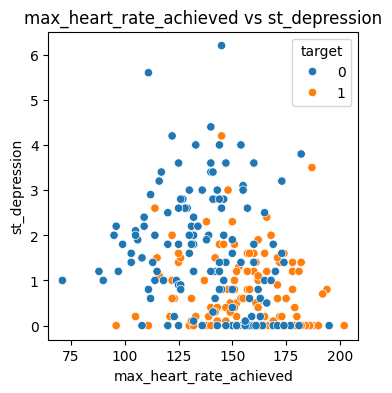

In [45]:
# scatter plot

def check_pair(pair, pair_dict):
    f1, f2 = pair
    # If f1 already has f2 recorded or vice versa → duplicate
    if f1 in pair_dict and f2 in pair_dict[f1]:
        return False
    if f2 in pair_dict and f1 in pair_dict[f2]:
        return False
    return True

def append_pair(pair, pair_dict):
    f1, f2 = pair
    pair_dict.setdefault(f1, []).append(f2)
    pair_dict.setdefault(f2, []).append(f1)

pair_dict = dict()

for f1 in ['age', 'cholesterol', 'resting_blood_pressure', 'max_heart_rate_achieved', 'st_depression']:
  for f2 in ['age', 'cholesterol', 'resting_blood_pressure', 'max_heart_rate_achieved', 'st_depression']:
    if f1 == f2:
      continue
    else:
      pair = (f1, f2)
      if check_pair(pair, pair_dict):
        append_pair(pair, pair_dict)
        plt.figure(figsize=(4,4))
        sns.scatterplot(data=df, x=f1, y=f2, hue='target')
        plt.title(f'{f1} vs {f2}')
        plt.show()

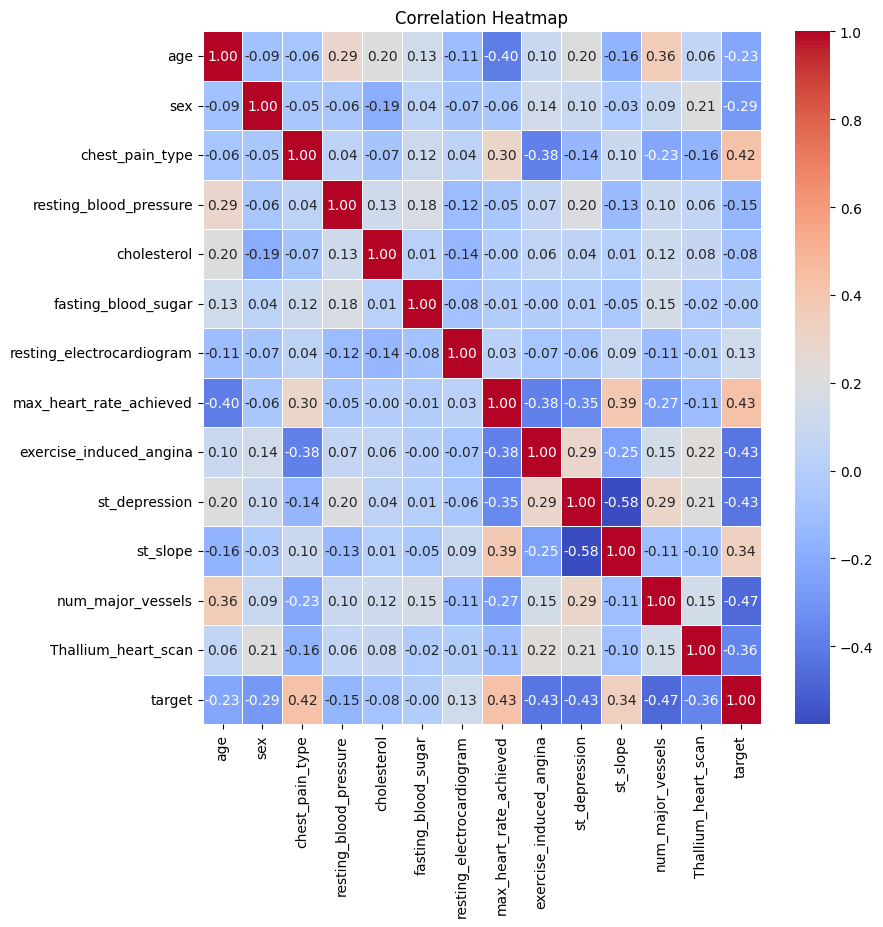

In [ ]:
# Correlation heatmap
corr_matrix = df.corr()
plt.figure(figsize=(9,9))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

In [16]:
corr_matrix['target']

age                         -0.225453
sex                         -0.285322
chest_pain_type              0.423425
resting_blood_pressure      -0.148922
cholesterol                 -0.076541
fasting_blood_sugar         -0.004680
resting_electrocardiogram    0.131716
max_heart_rate_achieved      0.426655
exercise_induced_angina     -0.425085
st_depression               -0.428804
st_slope                     0.337825
num_major_vessels           -0.467158
Thallium_heart_scan         -0.364399
target                       1.000000
Name: target, dtype: float64

In [17]:
# checking if dataset is misbalanced
df['target'].value_counts() / df.shape[0]

target
1    0.540541
0    0.459459
Name: count, dtype: float64

In [18]:
df.columns

Index(['age', 'sex', 'chest_pain_type', 'resting_blood_pressure',
       'cholesterol', 'fasting_blood_sugar', 'resting_electrocardiogram',
       'max_heart_rate_achieved', 'exercise_induced_angina', 'st_depression',
       'st_slope', 'num_major_vessels', 'Thallium_heart_scan', 'target'],
      dtype='object')

## Model training

Independent variable: Target \
Dependent variable:  ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure',
       'cholesterol', 'fasting_blood_sugar', 'resting_electrocardiogram',
       'max_heart_rate_achieved', 'exercise_induced_angina', 'st_depression',
       'st_slope', 'num_major_vessels', 'Thallium_heart_scan']

In [19]:
df.shape

(296, 14)

In [20]:
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiogram,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,Thallium_heart_scan,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [21]:
y = df['target']
X = df.drop(['target'], axis=1)

In [22]:
y.shape, X.shape

((296,), (296, 13))

In [23]:
seed = 42
# train test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=seed)

In [24]:
X_train.shape, X_test.shape

((222, 13), (74, 13))

In [25]:
def save_result_data(result_data, csv_file_path="training-log/model_result.csv", dir='training-log'):
    if os.path.exists(dir):
        with open(csv_file_path, 'a') as csvfile:
            csvwriter = csv.writer(csvfile)   
            csvwriter.writerow(result_data)
    else:
        os.makedirs(dir, exist_ok=True)
        with open(csv_file_path, 'w') as csvfile:
            csvwriter = csv.writer(csvfile)   
            csvwriter.writerow(['Name', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'ROC_AUC Score'])
            csvwriter.writerow(result_data)

    csvfile.close()

def model_save(model,file_name, dir='model'):
    path = os.path.join(dir, file_name)

    if os.path.exists(dir):
        pass
    else:
        os.mkdir(dir)
        
    with open(path, 'wb') as file:
        pickle.dump(model, file)

In [47]:
def roc_auc_display(test_result, model_name):
    # print(test_result)
    plt.figure(figsize=(7,7))
    for name in model_name:
        fpr, tpr, _ = roc_curve(test_result['y_test'], test_result[name] )
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Two Models')
    plt.legend()
    plt.show()

def evaluate_model(model_list, model_name):
    pred_log = {'y_test': y_test}
    model_dict = {}
    results_list = []  

    save_result_data(['New_Run', '---------', '---------', '---------','---------','---------']) 

    for model, name in zip(model_list, model_name):
        # train & predict
        model_base = model
        model_base.fit(X_train, y_train)
        y_pred = model_base.predict(X_test)

        # save predictions and model
        pred_log[name] = y_pred
        model_dict[name] = model_base

        # compute metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        # append to results list for DataFrame
        results_list.append({
            'Name': name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1 score': f1,
            'ROC_AUC': roc,
            'Confusion_Matrix': cm  
        })

        result = [name, acc, prec, rec, f1, roc]
        save_result_data(result)        

        file_name = name + ".pkl"
        model_save(model_base, file_name)  

    # build DataFrame and print a rounded view for neat output
    results_df = pd.DataFrame(results_list)
    display_df = results_df.copy()
    numeric_cols = ['Accuracy', 'Precision', 'Recall', 'F1 score', 'ROC_AUC']
    display_df[numeric_cols] = display_df[numeric_cols].round(4)
    print(display_df.to_string(index=False))

    return pred_log, model_dict, results_df


In [48]:
# Model 
model_logistic_regression_1 = LogisticRegression()
model_logistic_regression_2 = LogisticRegression(solver='liblinear', random_state=seed)
model_clf = RandomForestClassifier(random_state=seed)
model_gb = GradientBoostingClassifier(random_state=seed)
model_ada = AdaBoostClassifier(random_state=seed)
model_clf_2 = RandomForestClassifier(n_estimators=100, random_state=seed)
model_gb_2 = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model_ada_2 = AdaBoostClassifier(n_estimators=100, random_state=seed)
model_dt_gini = DecisionTreeClassifier(criterion='gini', random_state=seed)
model_dt_en = DecisionTreeClassifier(criterion='entropy', random_state=seed)
model_knn = KNeighborsClassifier(n_neighbors=2)
model_knn_2 = KNeighborsClassifier(n_neighbors=5)
model_svc = SVC() 
model_svc_2 = SVC(probability=True, random_state=seed)
model_gnb = GaussianNB()
model_bnb = BernoulliNB()
model_mlp = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=100, random_state=seed)

model_list = [model_logistic_regression_1, model_logistic_regression_2, model_clf, model_gb, model_ada, model_clf_2, 
              model_gb_2, model_ada_2, model_dt_gini, model_dt_en, model_knn, model_knn_2, model_svc, model_svc_2, 
              model_gnb, model_bnb, model_mlp ]
model_name = ["lr_1", "lr_2", "clf", "gb", "ada", "clf_2", "gb_2", "ada_2", "dt_gini", 
              "dt_en", "knn", "knn_2", "svc", "svc_2", "gnb", "bnb", "mlp"]

pred_log, model_dict, results_df = evaluate_model(model_list, model_name)


   Name  Accuracy  Precision  Recall  F1 score  ROC_AUC    Confusion_Matrix
   lr_1    0.8919     0.9231  0.8780    0.9000   0.8936  [[30, 3], [5, 36]]
   lr_2    0.8919     0.9231  0.8780    0.9000   0.8936  [[30, 3], [5, 36]]
    clf    0.8784     0.9000  0.8780    0.8889   0.8784  [[29, 4], [5, 36]]
     gb    0.8378     0.8537  0.8537    0.8537   0.8359  [[27, 6], [6, 35]]
    ada    0.9189     0.9268  0.9268    0.9268   0.9180  [[30, 3], [3, 38]]
  clf_2    0.8784     0.9000  0.8780    0.8889   0.8784  [[29, 4], [5, 36]]
   gb_2    0.8378     0.8537  0.8537    0.8537   0.8359  [[27, 6], [6, 35]]
  ada_2    0.8784     0.9211  0.8537    0.8861   0.8814  [[30, 3], [6, 35]]
dt_gini    0.7568     0.8286  0.7073    0.7632   0.7627 [[27, 6], [12, 29]]
  dt_en    0.7838     0.8378  0.7561    0.7949   0.7871 [[27, 6], [10, 31]]
    knn    0.6081     0.7500  0.4390    0.5538   0.6286 [[27, 6], [23, 18]]
  knn_2    0.7432     0.7619  0.7805    0.7711   0.7387 [[23, 10], [9, 32]]
    svc    0

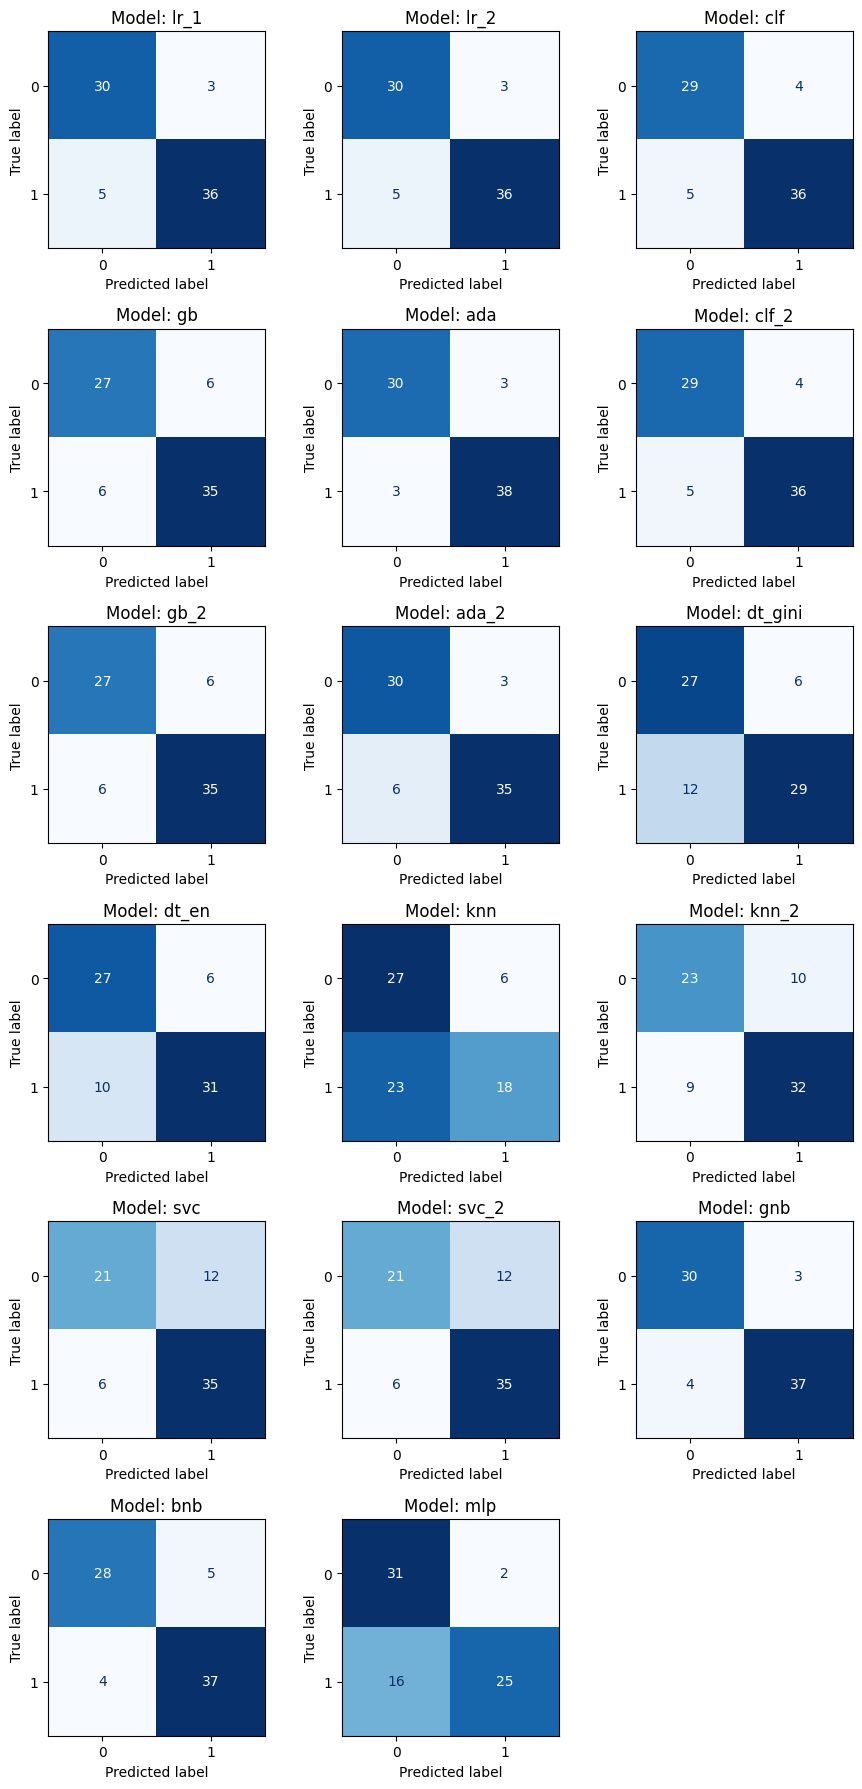

In [29]:
# number of plots per row
n_cols = 3
n_models = len(results_df)
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 3 * n_rows))  # adjust width & height
axes = axes.flatten()  # flatten in case of multiple rows

for i, (_, row) in enumerate(results_df.iterrows()):
    name = row['Name']
    cm = row['Confusion_Matrix']
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], cmap="Blues", values_format="d", colorbar=False)
    axes[i].set_title(f'Model: {name}')

# Hide any unused subplots if models < n_cols * n_rows
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


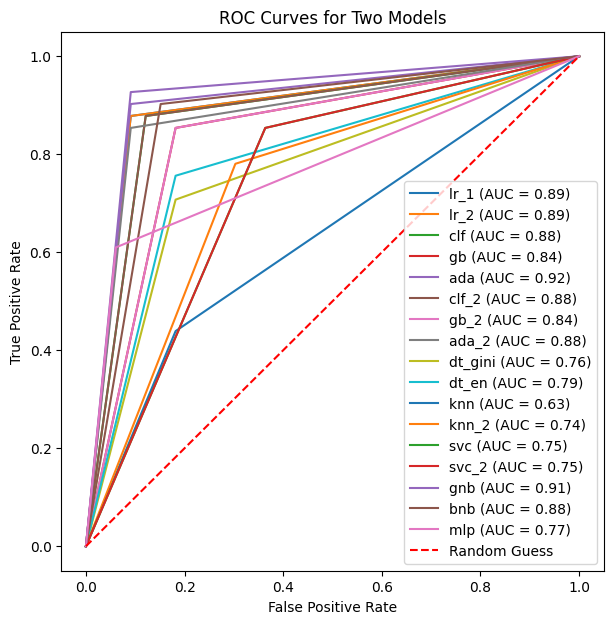

In [30]:
roc_auc_display(pred_log, model_name)

Out of all the models tested, Logistic Regression, AdaBoost, and Gaussian Naïve Bayes have shown the best performance. Moving forward, we will focus on these three models by applying cross-validation to ensure their robustness and performing hyperparameter tuning to optimize their predictive accuracy.

## Hyperparameter Turning

In [31]:
lr = LogisticRegression(tol=1e-4, max_iter=1000, random_state=seed)

space = dict(C=uniform(loc=0, scale=5),
                     penalty=['l2', 'l1'],
                     solver= ['liblinear'])

search = RandomizedSearchCV(lr, 
                         space, 
                         random_state=seed,
                         cv = 5, 
                         scoring='f1')

rand_search = search.fit(X_train, y_train)
print('Best Hyperparameters: %s' % rand_search.best_params_)

params = rand_search.best_params_
lr = LogisticRegression(**params)
lr.fit(X_train, y_train)
print(classification_report(y_test, lr.predict(X_test)))

Best Hyperparameters: {'C': np.float64(1.8727005942368125), 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.86      0.91      0.88        33
           1       0.92      0.88      0.90        41

    accuracy                           0.89        74
   macro avg       0.89      0.89      0.89        74
weighted avg       0.89      0.89      0.89        74



In [ ]:
X, y = df.drop("target", axis=1), df["target"]

def objective(trial):
    model_name = trial.suggest_categorical("model", ["svc", "knn", "gb"])

    if model_name == "svc":
        params = {
            "C": trial.suggest_loguniform("C", 1e-3, 1e3),
            "gamma": trial.suggest_loguniform("gamma", 1e-4, 1e1),
            "kernel": trial.suggest_categorical("kernel", ["rbf", "poly", "sigmoid"])
        }
        model = SVC(**params)

    elif model_name == "knn":
        params = {
            "n_neighbors": trial.suggest_int("n_neighbors", 3, 50),
            "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
            "p": trial.suggest_int("p", 1, 2)  # 1=manhattan, 2=euclidean
        }
        model = KNeighborsClassifier(**params)

    elif model_name == "gb":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.3),
            "max_depth": trial.suggest_int("max_depth", 2, 10),
            "subsample": trial.suggest_uniform("subsample", 0.5, 1.0)
        }
        model = GradientBoostingClassifier(**params)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    return scores.mean()

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best Trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ", study.best_trial.params)

In [49]:
# Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['saga']  # saga supports l1, l2, elasticnet, none
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=5000), param_grid_lr, cv=5, scoring='f1')
grid_lr.fit(X_train, y_train)

# GaussianNB
param_grid_nb = {
    'var_smoothing': np.logspace(-9, -1, 10)
}
grid_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=5, scoring='f1')
grid_nb.fit(X_train, y_train)

# AdaBoost
param_grid_ab = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 1]
}
grid_ab = GridSearchCV(AdaBoostClassifier(), param_grid_ab, cv=5, scoring='f1')
grid_ab.fit(X_train, y_train)

print("Best Logistic Regression params:", grid_lr.best_params_)
print("Best GaussianNB params:", grid_nb.best_params_)
print("Best AdaBoost params:", grid_ab.best_params_)

Best Logistic Regression params: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Best GaussianNB params: {'var_smoothing': np.float64(0.00021544346900318823)}
Best AdaBoost params: {'learning_rate': 0.01, 'n_estimators': 100}


In [50]:
print("Model: Grid LR\n",classification_report(y_test, grid_lr.predict(X_test), digits=4))
print("Model: Grid NB\n", classification_report(y_test, grid_nb.predict(X_test), digits=4))
print("Model: Grid Adaboost\n", classification_report(y_test, grid_ab.predict(X_test), digits=4))

Model: Grid LR
               precision    recall  f1-score   support

           0     0.9062    0.8788    0.8923        33
           1     0.9048    0.9268    0.9157        41

    accuracy                         0.9054        74
   macro avg     0.9055    0.9028    0.9040        74
weighted avg     0.9054    0.9054    0.9052        74

Model: Grid NB
               precision    recall  f1-score   support

           0     0.8235    0.8485    0.8358        33
           1     0.8750    0.8537    0.8642        41

    accuracy                         0.8514        74
   macro avg     0.8493    0.8511    0.8500        74
weighted avg     0.8520    0.8514    0.8515        74

Model: Grid Adaboost
               precision    recall  f1-score   support

           0     0.9333    0.8485    0.8889        33
           1     0.8864    0.9512    0.9176        41

    accuracy                         0.9054        74
   macro avg     0.9098    0.8999    0.9033        74
weighted avg     0.9

Apart from logistic regression, the other two models have experienced degradation in the performance metrics

## Cross validation

In [51]:
params = grid_lr.best_params_
lr = LogisticRegression(**params, max_iter=5000)
lr.fit(X_train, y_train)
print(classification_report(y_test, lr.predict(X_test), digits=4))

              precision    recall  f1-score   support

           0     0.9062    0.8788    0.8923        33
           1     0.9048    0.9268    0.9157        41

    accuracy                         0.9054        74
   macro avg     0.9055    0.9028    0.9040        74
weighted avg     0.9054    0.9054    0.9052        74



In [61]:
def perform_cross_validation(model_name, model_list, cv=None):
    for name, model in zip(model_name, model_list):
        cross_val_results = cross_val_score(model, X, y, cv=cv)

        print(f"\nCross-Validation Results of {name} (Accuracy):")
        for i, result in enumerate(cross_val_results, 1):
            print(f"  Fold {i}: {result * 100:.2f}%")
            
        print(f'Mean Accuracy {name}: {cross_val_results.mean()* 100:.2f}%')

In [62]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

cv_lr = LogisticRegression(**params, max_iter=5000)
cv_ada = AdaBoostClassifier(random_state=seed)
cv_gnb = GaussianNB()

model_cv = [cv_lr, cv_ada, cv_gnb]
model_name = ['cv_lr', 'cv_ada', 'cv_gnb']
perform_cross_validation(model_name, model_cv, kf)


Cross-Validation Results of cv_lr (Accuracy):
  Fold 1: 90.00%
  Fold 2: 84.75%
  Fold 3: 69.49%
  Fold 4: 83.05%
  Fold 5: 83.05%
Mean Accuracy cv_lr: 82.07%

Cross-Validation Results of cv_ada (Accuracy):
  Fold 1: 86.67%
  Fold 2: 83.05%
  Fold 3: 81.36%
  Fold 4: 83.05%
  Fold 5: 77.97%
Mean Accuracy cv_ada: 82.42%

Cross-Validation Results of cv_gnb (Accuracy):
  Fold 1: 90.00%
  Fold 2: 86.44%
  Fold 3: 76.27%
  Fold 4: 84.75%
  Fold 5: 79.66%
Mean Accuracy cv_gnb: 83.42%


## Explainability

In [35]:
# Feature importance
print("Feature importance (Logistic Regression) (Coefficient and Odds Ratio):: ")
model_dict_reg = lr

# Coefficients and Odds Ratios
coefficients = model_dict_reg.coef_[0]
odds_ratios = np.exp(coefficients)


# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print(feature_importance.sort_values(by='Coefficient', ascending=False))

Feature importance (Logistic Regression) (Coefficient and Odds Ratio):: 
                      Feature  Coefficient  Odds Ratio
2             chest_pain_type     0.592197    1.807956
10                   st_slope     0.193427    1.213401
6   resting_electrocardiogram     0.154640    1.167237
5         fasting_blood_sugar     0.030727    1.031204
7     max_heart_rate_achieved     0.025629    1.025960
0                         age     0.012031    1.012103
4                 cholesterol    -0.001996    0.998006
3      resting_blood_pressure    -0.018691    0.981483
8     exercise_induced_angina    -0.298456    0.741963
9               st_depression    -0.444378    0.641223
12        Thallium_heart_scan    -0.463641    0.628989
1                         sex    -0.516847    0.596398
11          num_major_vessels    -0.706111    0.493560


Feature importance (Random Forest) (Coefficient and Odds Ratio):: 


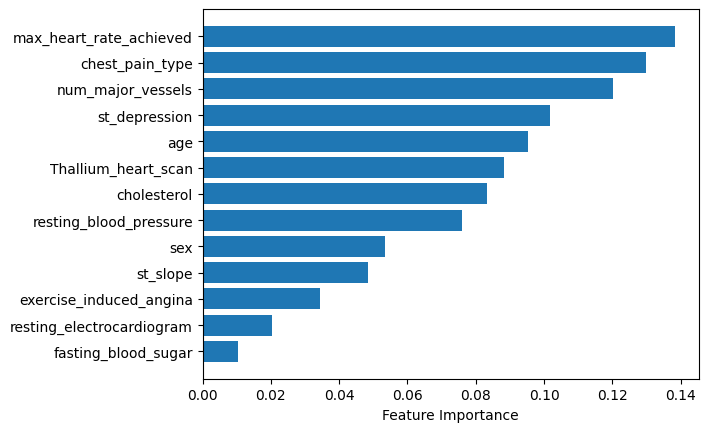

In [36]:
# Feature importance
print("Feature importance (Random Forest) (Coefficient and Odds Ratio):: ")
clf = model_dict['clf_2']
importances = clf.feature_importances_
feature_names = X.columns
sorted_idx = importances.argsort()

plt.barh(range(len(importances)), importances[sorted_idx])
plt.yticks(range(len(importances)), feature_names[sorted_idx])
plt.xlabel("Feature Importance")
plt.show()

## Conclusion from Feature Importance

- Most Influential Factors:

  - Max heart rate achieved and chest pain type are the strongest predictors. This suggests that exercise capacity and symptoms during exertion are critical indicators of heart disease risk.
  - Number of major vessels and ST depression also rank highly, highlighting the role of blood flow blockages and ECG abnormalities.

- Moderately Important Factors:

  - Age, Thallium heart scan results, cholesterol, and resting blood pressure contribute meaningfully, showing that traditional cardiovascular risk factors still hold weight.

- Less Influential Factors:

  - Sex, ST slope, exercise-induced angina, resting ECG, and fasting blood sugar have lower importance, suggesting they are less decisive in this dataset/model, though they still add some predictive value.

## Potential Preventive Measures or Lifestyle Changes Based on Risk Factors

1. Chest Pain Type (Angina/Chest Discomfort)

   - Preventive Measures:

     - Early medical evaluation for recurring chest pain.
     - Regular cardiovascular check-ups.
     - Use of prescribed medications for hypertension, high cholesterol, or angina.
   - Lifestyle Changes:

     - Stress management (yoga, meditation, therapy).
     - Avoiding smoking and excessive alcohol intake.
     - Maintaining a heart-healthy diet (low sodium, high fiber, lean proteins).

2. ST Slope (Abnormal ECG indicating ischemia)

   - Preventive Measures:

     - Regular monitoring of heart electrical activity.
     - Timely interventions like exercise stress tests or echocardiography.
   - Lifestyle Changes:

     - Consistent moderate exercise tailored to tolerance.
     - Limiting high-fat and processed foods.
     - Compliance with medications (e.g., for blood pressure, cholesterol).

3. Resting Electrocardiogram (Abnormal Resting ECG)

   - Preventive Measures:

     - Routine ECG check-ups, especially for high-risk individuals.
     - Immediate evaluation of any abnormal heart rhythm or conduction issue.
   - Lifestyle Changes:

     - Reduce caffeine and stimulant intake.
     - Ensure adequate sleep and recovery.
     - Managing comorbidities (diabetes, hypertension).

4. Fasting Blood Sugar (Diabetes or Prediabetes)

   - Preventive Measures:

     - Regular blood sugar screening.
     - Early treatment of prediabetes with diet and exercise.
   - Lifestyle Changes:

     - Balanced diet (low in refined sugars, more whole grains).
     - Weight management and regular physical activity.
     - Consistent monitoring of blood glucose levels.

5. Max Heart Rate Achieved (Low values may suggest poor exercise capacity)

   - Preventive Measures:

     - Gradual and supervised exercise programs to improve cardiovascular fitness.
     - Stress tests to assess cardiac response.
   - Lifestyle Changes:

     - Engage in aerobic exercise (walking, swimming, cycling).
     - Avoid overexertion; follow a structured fitness plan approved by a doctor.
     - Regular monitoring during exercise.

6. Age (Non-modifiable risk factor)

   - Preventive Measures:

     - More frequent screening as age increases.
     - Use of preventive medications if risk is high.
   - Lifestyle Changes:

     - Maintain healthy habits throughout aging.
     - Social engagement and mental health care (reduces stress-related cardiac risks).
     - Prioritize preventive healthcare (vaccines, regular checkups).


## Ethical Considerations in Using Predictive Models for Healthcare

1. Fairness and Bias

   - Models may reflect biases in training data (e.g., underrepresentation of certain age groups, genders, or ethnicities).
   - Risk of unfair treatment or misdiagnosis if predictions are skewed.

2. Transparency and Explainability

   - Patients and doctors should understand why the model predicts high risk.
   - Black-box predictions without explanation can reduce trust and hinder informed decisions.

3. Privacy and Data Security

   - Sensitive health data must be protected from misuse or breaches.
   - Consent is crucial when collecting and using patient data.

4. Over-Reliance on Models

   - Models should support, not replace, clinical judgment.
   - Ethical risk if doctors blindly follow predictions without considering patient context.

5. Psychological Impact

   - Labeling someone as “high risk” may cause unnecessary anxiety.
   - Communication should be careful, with emphasis on preventive steps.

6. Access and Equity

   - Predictive healthcare tools should be accessible to all, not just those in well-funded healthcare systems.
   - Risk of widening healthcare disparities if only some groups benefit.
